# Exercício 2 - Enunciado


2. O Conway’s Game of Life é um exemplo conhecido de um autómato celular . Aqui vamos modificar as regras do autómato de forma a usar um espaço de estados finito
    1. O espaço de estados é definido por uma grelha de células booleanas (morta=0/viva=1) de dimensão $\,N\times N\,$ (com $N>3$) identificadas por índices $\,(i,j)\in \{1..N\}$.  Estas $\;N\uparrow2\;$ células são aqui referidas como “normais”. 
    2. Inicialmente todas as células normais estão mortas excepto  as células $\,i,j \leq 3\,$que estão vivas. Um estado onde todas as células normais estão mortas é um “estado de erro”.
    3. Adicionalmente existem $\,2\,N+1\,$ “células da borda” que correspondem a um dos índices, $i$ ou $j$, ser zero. As células da borda têm valores constantes que, no estado inicial, são gerados aleatoriamente com uma probabilidade $\,1/2\,$ de estarem vivas.
    4. As células normais o autómato modificam o estado de acordo com a regra “B3/S23”: i.e. a célula nasce (passa de $0$ a $1$) se tem exatamente 3 vizinhos vivos e sobrevive (mantém-se viva) se o número de vizinhos vivos é 2 ou 3, caso contrário morre ou continua morta.

*A célula $\;(i_0,j_0)\;$e $\,(i_1,j_1)\,$ são vizinhas sse $\;(i_0-i_1=\pm 1) \,\lor\, (j_0-j_1 = \pm 1)$*

Pretende-se:

    1. Construir uma máquina de estados finita que represente este autómato.
    2. Provar as seguintes propriedades:
        1. Nunca se alcança o estado de erro
        2. Nenhuma célula normal está permanentemente morta ou permanentemente viva.

# Exercício 2 - Solução

Pretendemos construir a FSM que representa o autómato celular do GoL (Game of Life) e provar as duas propriedades do enunciado.

No entanto, de forma a verificar o funcionamento esperado deste autómato, começemos pela criação da FSM e com a criação de código que procure animar o autómato.

## Criação da FSM e Animação do GoL

In [4]:
from pysmt.shortcuts import Solver, Symbol,  And, Or, Implies, Not
from pysmt.shortcuts import Equals, Int, GT, LE, LT, Plus, Minus
from pysmt.shortcuts import is_sat, get_model, AllDifferent
from pysmt.typing import INT
from random import choices
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

Começemos por definir uma classe que defina os estados deste autómato.

Nesta conceção de estado, teremos informação sofre quais células estão vivas e em que elemento do traço nos encontramos.

In [5]:
class ST:
    def __init__(self, s=''):
        self.living = []
        self.pc = Symbol(s+'.pc', INT)
    def __str__(self):
        return f"({str(self.cell)},  {str(self.pc)})"

Consideremos $N = \{0,\dots,9\}$, teremos o conjunto $N \uparrow 2$ de cardinalidade $100$ com um total de $121$ células incluindo as *Border Cells*.

Ora, com isto, criemos o tabuleiro de jogo:

In [6]:
N = 5
table = [[Symbol('s'+str(i)+str(j)) for j in range(N+1)] for i in range(N+1)]

Note-se também que o "Jogo da Vida" de Conway é **indecidível**, sendo assim, a cardinalidade do traço tenderá para o infinito.

Sendo assim, limitemos superiormente a execução por um número arbitrário:

In [7]:
M = 500

trace= [ST('s'+str(i)) for i in range(M)]

Teremos então de inicializar a tabela com os requisitos, começemos por diferenciar células normais de células de fronteira:

In [8]:
live_init_ncell = {table[1][1],table[1][2],table[1][3],
                  table[2][1],table[2][2],table[2][3],
                  table[3][1],table[3][2],table[3][3]}
bcell = set()
for i in range(N+1):
    for j in range(N+1):
        if i == 0 or j == 0:
            bcell.add(table[i][j])
dead_init_ncell = {table[i][j] for i in range(N+1) for j in range(N+1) if table[i][j] not in live_init_ncell and table[i][j] not in bcell}

Com isto podemos definir a configuração inicial das células normais através de uma simples restrição lógica:

In [9]:
prob = And(Not(And(dead_init_ncell)),And(live_init_ncell))

Com isto, podemos proceder a inicializar as células que se encontram na fronteira.

Ora, estas são inicializadas de forma aleatória com uma probabilidade de nascer de $\frac{1}{2}$.

De notar que uma biblioteca Standard (`random`) contem a subrotina (`choices`) que permite gerar resultados aleatórios com pesos.

In [10]:
distribution = [choices([False,True], [0.5,0.5]) for i in range(2*N+1)]
bcell_list = list(bcell)
for i in range(len(bcell_list)):
    if distribution[i][0]:
        prob = And(prob, bcell_list[i])
    else:
        prob = And(prob, Not(bcell_list[i]))

Finalmente, podemos proceder com a implementação de alguma subrotina que conte o número de células vizinhas vivas:

In [28]:
def living_neigh(table, solver, study):
    count = 0;
    x, y = study
    # i_0 - i_1 = +- 1 OR j_0 - j_1 = +- 1
    your_arr = [[solver.get_value(table[i][j]).constant_value() for j in range(N+1) if (abs((x - i)) == 1 or abs((y - j)) == 1) and solver.get_value(table[i][j]).constant_value()] for i in range(N+1)]
    count = len(your_arr)
    return count;

Estamos finalmente em vias de resolver algum modo de animar o nosso problema, tentaremos,
então animar a primeira configuração do Autómato Celular a ser estudado:

6


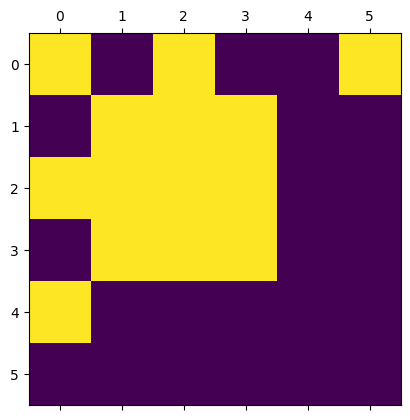

In [29]:
with Solver() as solver:
    solver.add_assertion(prob);
    if solver.solve():
        your_arr = [[solver.get_value(table[i][j]).constant_value() for j in range(N+1)] for i in range(N+1)]
        plt.matshow(your_arr) #, cmap='gray')
        print(living_neigh(table, solver, (0,0)))
        #pprint([[solver.get_value(table[i][j]) for j in range(N)] for i in range(N)])

## Verificação das Propriedades